# CLASE 2.7: Métodos de ensamble
---
## Introducción.
En la sección anterior, exploramos en detalle los árboles de decisión, un tipo de modelo de aprendizaje supervisado que es capaz de aprender reglas de decisión a partir de los datos y aplicarlas de manera interpretativa. Sin embargo, los árboles de decisión presentan ciertos desafíos: Pueden ser altamente sensibles al ruido y al overfitting, y limitados en su capacidad de generalización.

Para abordar estos problemas, en esta sección exploraremos una de las técnicas más poderosas en aprendizaje automático moderno: Los **métodos de ensamble**. En términos simples, en lugar de depender de un único modelo (cualquiera sea éste), los métodos de ensamble combinan múltiples modelos más simples para crear un modelo más fuerte y robusto. Esto nos permite reducir la varianza, mejorar la precisión y aumentar la estabilidad de las predicciones.

Los métodos de ensamble aprovechan la idea de que **varios modelos débiles pueden acoplarse para crear un modelo fuerte**. En otras palabras, cada modelo base puede cometer errores en diferentes partes del espacio de entrada, pero al combinar sus predicciones de manera "inteligente", podemos construir un modelo "colectivo" que generalice mejor que cualquiera de sus componentes individuales.

Entre los enfoques más populares que estudiaremos en esta sección, tenemos:

- **Voting (votación por mayoría o ponderada):** Método simple pero poderoso en el que combinamos múltiples modelos de distinto tipo (por ejemplo, árboles de decisión, regresión logística y máquinas de soporte vectorial) y tomamos la predicción final basada en un voto mayoritario (clasificación) o un promedio ponderado (regresión).

- **Bagging (acrónimo del inglés *bootstrap aggregating*):** Técnica en la que entrenamos múltiples modelos en subconjuntos aleatorios de los datos de entrenamiento y combinamos sus predicciones de una manera agregada (por ejemplo, promediándolas o usando su moda). El ejemplo más conocido de esta técnica de ensamble es el **modelo de bosque aleatorizado** es **random forest**, y que comúnmente se considera una extensión "natural" de los modelos de árbol de decisión.

- **Boosting:** Enfoque similar al anterior, pero en el cual los modelos se entrenan secuencialmente, corrigiendo los errores de los modelos anteriores en un proceso más bien progresivo. Modelos tales como **Gradient Boosting Machines (GBM)**, **AdaBoost** y **XGBoost** han demostrado ser extremadamente eficaces en competencias de Machine Learning y aplicaciones industriales, y por lo general, representan el pináculo de los algoritmos clásicos de aprendizaje (esto es, descartando a las redes neuronales) y la herramienta más potente de la que dispondremos para construir modelos predictivos sobre datos tabulares.

- **Stacking (generalización por apilamiento):** Estrategia que combina diferentes modelos base (en general, de naturalezas muy distintas entre sí), entrenando un "meta-modelo" que aprende cómo hacer la mejor combinación de sus predicciones.

Dado lo anterior, esta sección será, naturalmente, muchísimo más intensiva que la anterior. Desarrollaremos las bases de estas técnicas de ensamble y discutiremos sus pros y contras, tanto en la teoría como en la práctica valiéndonos de ejemplos en Python. Nuevamente, **<font color='mediumorchid'>Scikit-Learn</font>** se transformará en nuestro mayor aliado a la hora de implementar y practicar, aunque en esta oportunidad revisaremos algunas librerías adicionales especialidadas en el entrenamiento de este tipo de modelos, como **<font color='mediumorchid'>LightGBM</font>** y **<font color='mediumorchid'>XGBoost</font>**. Pondremos mucho énfasis en comparar el rendimiento de estos modelos con los otros que hemos estudiado previamente, ya que esta será la última sección de estos apuntes donde nos dedicaremos enteramente al aprendizaje supervisado.

## Voting.
Sea $\mathcal{D} =\left\{ \left( \mathbf{X} ,\mathbf{y} \right) :\mathbf{X} \in \mathbb{R}^{m\times n} \wedge \mathbf{y} \in \mathbb{R}^{m} \right\}$ un conjunto de entrenamiento, donde $\mathbf{X}$ es la correspondiente matriz de diseño e $\mathbf{y}$ el vector de valores observados que deseamos predecir. Sean $\mathcal{X}$ e $\mathcal{Y}$ los correspondientes espacios de entrada y salida que caracterizan a este conjunto de entrenamiento. Supongamos que hemos entrenado diferentes modelos en $\mathcal{D}$, digamos $f_{1},...,f_{r}$. Queremos, de alguna manera, tomar estos $r$ modelos y, en base a ellos, construir una especie de "meta-modelo" que tenga un desempeño superior a cualquiera de ellos de manera individual, agregando sus predicciones de forma adecuada, dependiendo del problema de interés (regresión o clasificación). Esta metodología es la aproximación más sencilla (aunque efectiva, en muchos casos) a un ensamble. Cada modelo individual, por tanto, constituye un predictor que contribuye al aprendizaje del ensamble completo.

<p style="text-align: center;"><img src="figures/fig_7_1.png" width="1000"></p>
<p style="text-align: center;">Fig. (7.1): Esquema sencillo que ilustra un "meta-modelo" construido a partir de un ensamble donde se destacan distintos predictores de diversa naturaleza (por ejemplo, modelos de regresión logística, árboles de decisión y máquinas de soporte vectorial)</p>

Bajo ciertas condiciones, este tipo de ensamble efectivamente puede lograr *siempre* mejores resultados que sus componentes individuales. Tales condiciones no son particularmente exigentes, pero determinarán el éxito de nuestro "meta-modelo", y dependerán del tipo de problema en cuestión. Por ejemplo, **para problemas de clasificación**

- Cada predictor individual tiene una probabilidad $p> \frac{1}{2}$ de acertar en su correspondiente predicción (es decir, cada una de las componentes del ensamble tiene un mejor desempeño sobre los datos de entrenamiento que un supuesto al azar).
- Los errores de los predictores son independientes (o al menos, no perfectamente correlacionados) entre sí.

Tomemos estos supuestos como base y supongamos que disponemos de un total de $r$ modelos de clasificación. Estos modelos pueden ser, incluso, juicios u opiniones expertas sobre la variable de respuesta de interés en nuestro conjunto de entrenamiento. Asumiremos que cada uno de estos modelos, por simplicidad, tendrá una probabilidad $p$ de acierto en sus correspondientes predicciones, siendo cada uno de sus valores de salida estadísticamente independientes entre sí. Definimos una colección de $r$ variables aleatorias $X_{1},...,X_{r}$ que mapearán el éxito de estos clasificadores:

$$X_{k}=\begin{cases}1&;\  \mathrm{si\  el\  predictor} \  k\  \mathrm{acierta}\\ 0&;\  \mathrm{si\  el\  predictor} \  k\  \mathrm{se\  equivoca}\end{cases}$$
<p style="text-align: right;">$(7.1)$</p>

Para $k=1,...,r$. De esta manera, $P(X_{k}=1)=p$. Definimos también:

$$S=\sum_{k=1}^{r} X_{k}$$
<p style="text-align: right;">$(7.2)$</p>

Y que corresponde al número total de modelos que aciertan en su predicción para una instancia de entrenamiento dada. Si diseñamos un ensamble que esté comprendido por estos $r$ modelos de clasificación, entonces éste acertará en su predicción "global" o "colectiva" si al menos la mitad de sus componentes aciertan; es decir, si $S\geq \left\lceil \frac{r}{2} \right\rceil$. De esta manera, la probabilidad de que el ensamble sea exitoso en sus predicciones puede expresarse como

$$\begin{array}{lll}P\left( \mathrm{ensamble\  acierta} \right)&=&\displaystyle P\left( S\geq \left\lceil \frac{p}{2} \right\rceil \right)\\ &=&\displaystyle \sum_{k=\left\lceil p/2 \right\rceil}^{r} \left( \begin{matrix}r\\ k\end{matrix} \right) p^{k}\left( 1-p \right)^{r-k}\end{array}$$
<p style="text-align: right;">$(7.3)$</p>

Es decir, el éxito en las predicciones del ensamble sigue una distribución de Bernoulli. Esta estrategia de evaluación de los aciertos de un ensamble sigue la misma lógica que una **votación mayoritaria**. Vale decir, la respuesta del ensamble será igual a la respuesta más frecuente de los predictores individuales. En la teoría del aprendizaje automático esta estrategia se conoce como **votación dura**.

Para cada uno de los componentes del ensamble, los errores de clasificación individuales están dados por la probabilidad complementaria $q=1-p$. Ya que $p>\frac{1}{2}$, necesariamente se tendrá que $q<\frac{1}{2}$. Por lo tanto, bajo las reglas de votación dura, la probabilidad de que el ensamble no acierte en sus predicciones será

$$\begin{array}{lll}P\left( \mathrm{ensamble\  no\  acierta} \right)&=&\displaystyle 1-P\left( S\geq \left\lceil \frac{p}{2} \right\rceil \right)\\ &=&\displaystyle P\left( S<\left\lceil \frac{p}{2} \right\rceil \right)\\ &=&\displaystyle \sum_{k=0}^{\left\lceil p/2 \right\rceil -1} \left( \begin{matrix}r\\ k\end{matrix} \right) p^{k}\left( 1-p \right)^{r-k}\end{array}$$
<p style="text-align: right;">$(7.4)$</p>

Cuando $p$ es impar, se tiene que $\left\lceil p/2 \right\rceil =\frac{p+1}{2}$. Por otro lado, cuando $p$ es par, entonces $\left\lceil p/2 \right\rceil =\frac{p}{2} +1$. En ambos casos, es posible demostrar que, cuando $p$ crece, esta probabilidad de error disminuye. Para ello, ilustraremos en un gráfico de Python el efecto de $p$ sobre el error cometido por un ensamble dependiendo de su tamaño (es decir, del número de modelos componentes). Para ello, partimos con las importaciones de librerías y funciones correspondientes:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
from math import comb

In [3]:
plt.rcParams["figure.dpi"] = 200
sns.set()
plt.style.use("bmh")

In [4]:
%matplotlib widget

A continuación, definiremos la función de masa de probabilidad para el error cometido por el ensamble en Python. Para ello, usaremos la fórmula de la última línea de la expresión (7.4):

In [5]:
def ensemble_error(p, n):
    """
    Calcula la probabilidad de que el ensamble falle (es decir, cometa un error) cuando cada clasificador 
    acierta con probabilidad `p` y hay `n` clasificadores independientes.
    """
    # Para mayoría en n clasificadores, se requiere >= (n//2 + 1) aciertos (si n es par), o >= (n+1)//2 
    # (si n es impar). Esto equivale a un "valor umbral".
    threshold = (n // 2) + 1  # mayoría absoluta

    # Probabilidad de error = P(S < threshold) = sum_{k=0}^{threshold - 1} [C(n,k) * p^k * (1-p)^(n-k)].
    error = 0.0
    for k in range(threshold):
        error += comb(n, k) * (p**k) * ((1 - p)**(n - k))
    return error

Ya sólo resta construir nuestro gráfico. Para ello, definimos una secuencia de `100` valores de probabilidad en el intervalo `[0, 1]` que almacenaremos en el arreglo `p_vals`. Luego, para observar el efecto del crecimiento de las probabilidades individuales y su efecto en el error del ensamble completo, definimos una lista con `200` tamaños posibles (o modelos componentes):

In [6]:
# Definimos un rango de valores de `p`.
p_vals = np.linspace(start=0.0, stop=1.0, num=100)

In [7]:
# Definimos distintos tamaños del ensamble para comparar los resultados.
n_estimators = np.arange(start=1, stop=200, step=1)

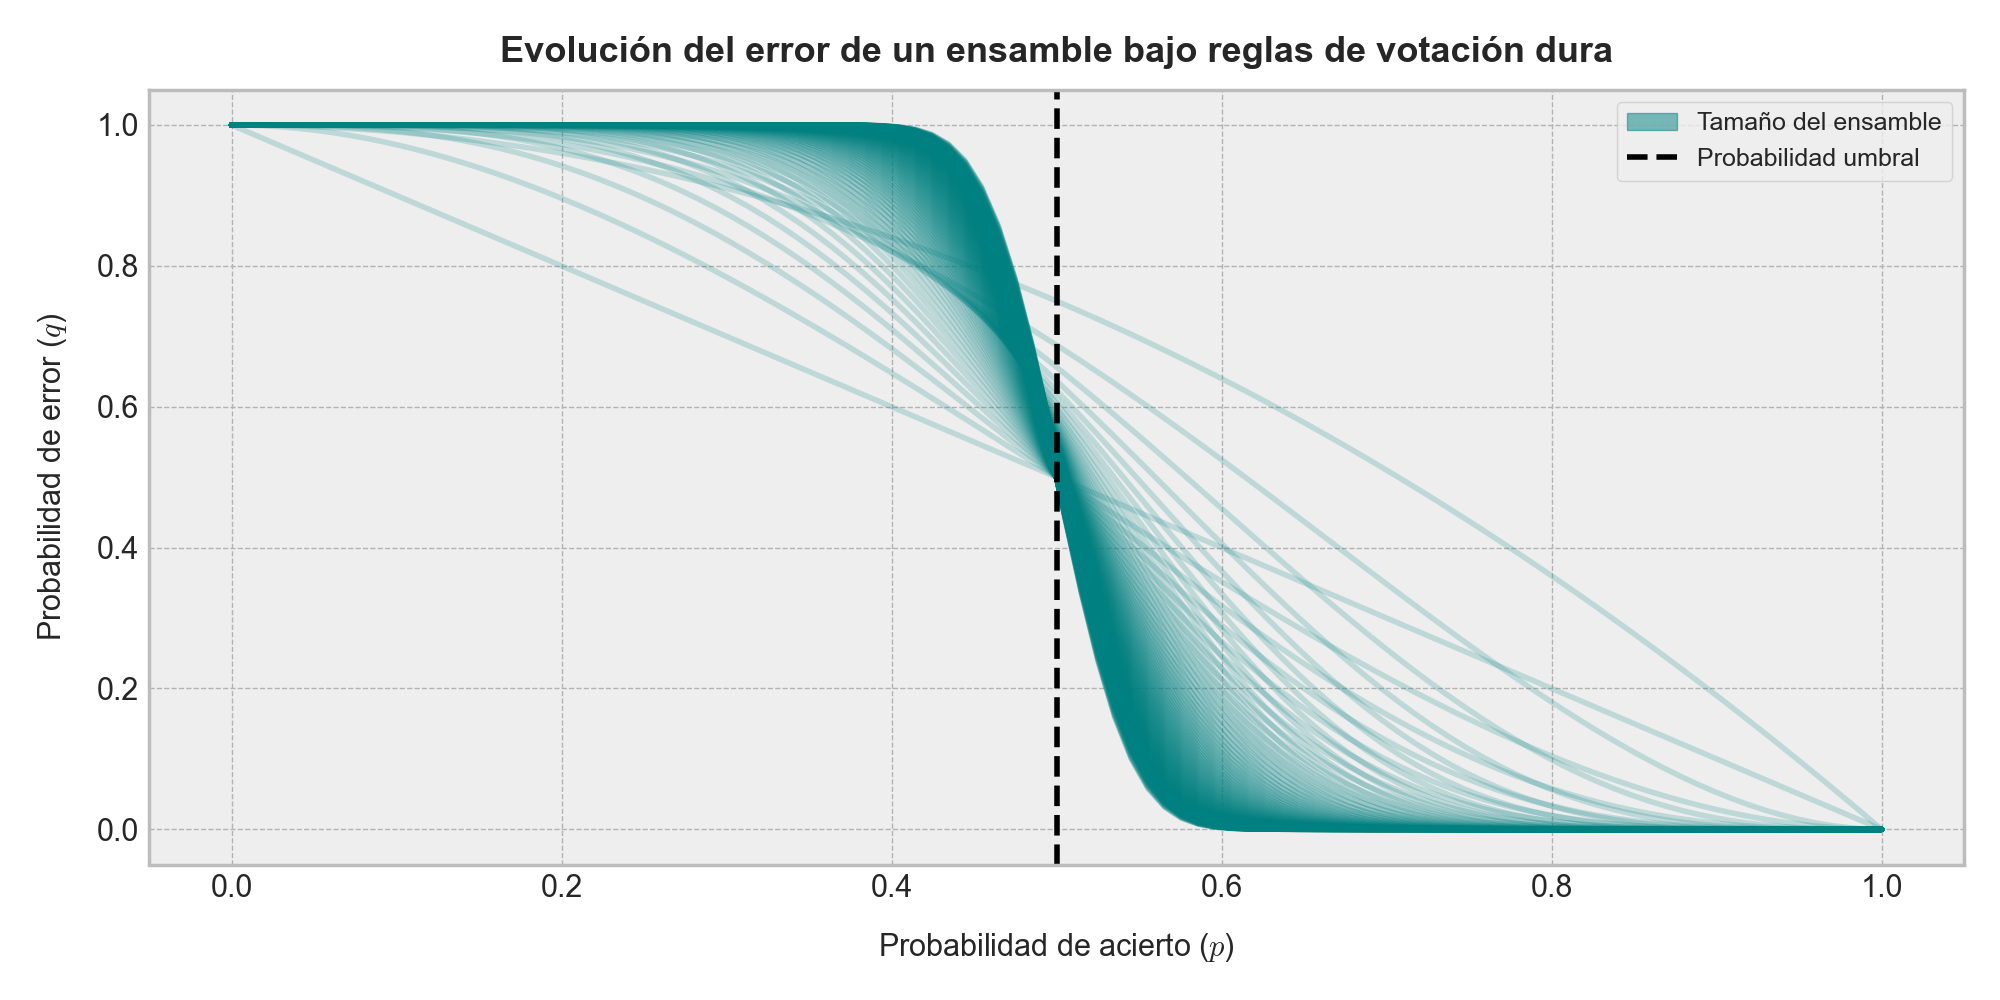

In [8]:
# Visualizamos el efecto de incrementar el valor de `p`.
fig, ax = plt.subplots(figsize=(10, 5))

for k in n_estimators:
    errors = [ensemble_error(p, k) for p in p_vals]
    ax.plot(p_vals, errors, color="teal", alpha=0.2)

ax.fill_between(
    x=[0, 0], y1=[0, 0], color="teal", ec="teal", alpha=0.5, 
    label="Tamaño del ensamble",
)
ax.axvline(x=0.5, color='black', linestyle='--', label="Probabilidad umbral")
ax.set_xlabel(r"Probabilidad de acierto ($p$)", fontsize=11, labelpad=10)
ax.set_ylabel(r"Probabilidad de error ($q$)", fontsize=11, labelpad=10)
ax.set_title(
    "Evolución del error de un ensamble bajo reglas de votación dura",
    fontsize=13, fontweight="bold", pad=10,
)
ax.legend(fontsize=9, frameon=True, loc="best")
plt.tight_layout();

Podemos observar que, efectivamente, independiente del tamaño del ensamble, las probabilidades de error siempre decrecen cuando $p$ es mayor que $0.5$ en forma monótona. Y más aún, mientras más grande es el ensamble, más rápido tenderá $q$ a cero. Sin embargo, hay un límite para esto: No podemos disponer de infinitos predictores individuales en el ensamble, ya que ello hará poco práctica cualquier implementación y/o entrenamiento, sobretodo si las componentes del ensamble son modelos de alta complejidad y/o pobre escalamiento con el número de variables.

Prosigamos desarrollando nuestra idea. Un resultado importante que suele ser utilizado para mostrar que un ensamble que cumple con las condiciones previamente establecidas producirá mejores resultados que sus componentes individuales, es el siguiente.

**<font color='indianred'>Teorema 7.1 – Jurado de Condorcet:</font>** *Sea $r$ un número impar y consideremos un conjunto de $r$ juicios u opiniones expertas (que, en la práctica, serán interpretadas a partir de modelos de clasificación). Admitimos que cada uno de los $r$ "jurados" (o modelos individuales) toma una decisión correcta de manera independiente con la misma probabilidad $p$, tal que $p>\frac{1}{2}$. Entonces se cumple que:*

- *La probabilidad de que la mayoría de esos $r$ jurados acierte es mayor que $p$.*
- *Además, dicha probabilidad tiende a $1$ a medida que $p\rightarrow \infty$*. □

Este resultado es famoso en ciencias políticas y sociales, porque muestra por qué un cuerpo colegiado (el cual tiene una constitución equivalente, en términos estadísticos, un ensamble de modelos de clasificación “independientes y competentes”) puede ser más fiable que cualquiera de sus miembros tomados aisladamente. En algunos cursos famosos de aprendizaje automático, esta regla suele denominarse de formas más "marketeras" (algunas más correctas que otras), como *wisdom of the crowd* o *best in class*.

Extendiendo la idea del teorema (7.1), para un número finito $r$ de modelos de clasificación, podemos distinguir que:

1. Si $p>\frac{1}{2}$, el valor esperado de aciertos del ensamble será $\mathrm{E} \left[ S \right] =rp$, el cual es mayor que $\frac{1}{2}$.
2. Por propiedades de la distribución de Bernoulli, la mayor parte de la masa en su función de probabilidad se concentra alrededor de la media $rp$. Al estar la media por encima de $p/2$, resulta más probable que $S\geq p/2$ que $S< p/2$.

Aplicando el teorema central del límite ([clase 1.5](https://github.com/rquezadac/udd_data_science_lectures/blob/main/PARTE%20I%20-%20Fundamentos%20matem%C3%A1ticos%20elementales/clase_1_5.ipynb)), generando una aproximación normal de $S$ cuando $r$ crece infinitamente, se tendrá que

$$S\sim \mathcal{N} \left( rp,rp\left( 1-p \right) \right)$$
<p style="text-align: right;">$(7.5)$</p>

Por lo tanto, la probabilidad de que $S\leq \frac{1}{2}$ puede calcularse como

$$\begin{array}{lll}\displaystyle P\left( S\geq \frac{p}{2} \right)&=&\displaystyle P\left( \frac{S-pr}{\sqrt{pr\left( 1-pr \right)}} \geq \frac{\frac{r}{2} -pr}{\sqrt{pr\left( 1-pr \right)}} \right)\\ &=&\displaystyle P\left( Z\geq \frac{\frac{r}{2} -pr}{\sqrt{pr\left( 1-pr \right)}} \right)\end{array}$$
<p style="text-align: right;">$(7.6)$</p>

Donde $Z$ es una variable aleatoria Gaussiana (de tipo estándar). Como $p>\frac{1}{2}$, el numerador $\frac{r}{2} -pr$ es negativo, por lo que la probabilidad de que $Z$ sea mayor que un número negativo es mayor que $\frac{1}{2}$ y aumenta con $r$. En consecuencia, la probabilidad de que el ensamble cometa un error tiende a cero cuando $p\rightarrow \infty$, mientras que el error $q$ de cada clasificador individual permanece fija en $1-p$. Aún con valores de $r$ no muy grandes, la reducción del error de clasificación por efecto del ensamble suele ser significativa cuando $p$ se mantiene por encima de $\frac{1}{2}$ y las correlaciones entre los predictores individuales no son muy altas.

En la práctica, los modelos de clasificación individuales no suelen ser estrictamente independientes; a menudo sus errores están correlacionados, porque, en general, nunca dispondremos de más de un conjunto de entrenamiento para entrenar cada modelo individual en cada uno. Sin embargo, si la correlación no es demasiado grande y cada clasificador sigue teniendo probabilidad de acierto $p>\frac{1}{2}$, la regla de votación dura o mayoritaria tiende a seguir mejorando el rendimiento promedio del ensamble, aunque el efecto no será tan drástico como en el caso ideal de independencia perfecta de los modelos individuales.